In [1]:
import pylab as plt
import numpy as np
import pandas as pd
import proposal as pp  #installed with pip
import scipy
from scipy import interpolate
from scipy.interpolate import griddata
from MCEq.core import config, MCEqRun
import crflux.models as crf
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
#import tables as tb
#import csv
import re

In [2]:
# a handy function to go from surface position to angles, depth, distance
def GetMuonInfo(startMuon):
    depthMuon   = np.round(depth(*startMuon)[0][0],2)
    distMuon    = np.round(rocklength(*startMuon)[0][0],2)
    thMuon      = np.round(np.arctan((startMuon[0]**2+startMuon[1]**2)**0.5/depthMuon),2)
    phiMuon     = np.round(np.arctan2(startMuon[1],startMuon[0]),2)
    return thMuon,phiMuon,depthMuon,distMuon

#This function does the business of calling PROPOSAL.
# It is configured in config.json to propagate the muon through a giant block of "standard rock"

def PropagateMuons(MuonEnergyToSimulate,DistToDetector,NumberToRun=1000):
    mu_def = pp.particle.MuMinusDef()
    prop = pp.Propagator(
        particle_def=mu_def,
        config_file="/Users/rogerslc/PROPOSAL/PROPOSAL/config.json"   #in the PROPOSAL resources directory
    )

    
    mu = pp.particle.DynamicData(mu_def.particle_type)

    mu.energy = MuonEnergyToSimulate
    mu.direction = pp.Vector3D(0, 0, -1)

    mu_position = []
    mu_energy = []

    for i in range(NumberToRun):
        sec = prop.propagate(mu,DistToDetector)
        slop=100
        if(np.abs(sec.position[-1].magnitude()-DistToDetector)<slop):
            mu_energy.append(sec.energy[-1])
            mu_position.append(sec.position[-1].magnitude()-DistToDetector)
            
    return mu_energy,mu_position

In [3]:
#to read file
pdmtn=pd.read_hdf('/Users/rogerslc/Documents/MuFluxPred/MountainProfile.h5')

StepSize=100
eps=0.1   # This is a trick to stop divide by zero errors

m_to_cm=100
GeV=1000

#putting coordinates in format for contour plot
Ymax=int(np.round(pdmtn['Y'].max(),0))
Xmax=int(np.round(pdmtn['X'].max(),0))
Ymin=int(np.round(pdmtn['Y'].min(),0))
Xmin=int(np.round(pdmtn['X'].min(),0))



vals=[]
X1= range(Xmin,Xmax, StepSize)
Y1= range(Ymin,Ymax, StepSize)
for ys in Y1:
    for xs in X1:   
        pts=pdmtn[(pdmtn.X>=xs) &(pdmtn.X<=xs+StepSize)&(pdmtn.Y>=ys) &(pdmtn.Y<=ys+StepSize)].Z.unique()
        if len(pts)==0:
            ptsz=200
        else:
            ptsz=np.mean(pts)       
        vals.append(ptsz)

vals = np.array(vals)

zz=vals.reshape(len(Y1), len(X1))
[xx,yy]=np.meshgrid(np.arange(Xmin,Xmax,StepSize),np.arange(Ymin,Ymax,StepSize))

#Find the thetas and phis and distance through rock for each grid square
phioffset=0                      # Orientation of detector relative to map - you need to figure this out.
rho=((xx+eps)**2+(yy+eps)**2)**0.5             # cylindrical rho coordinate
theta=np.arctan(rho/(zz+eps))           # spherical theta coordinate (0 = downgoing)
phi = np.arctan2((yy+eps),(xx+eps)) + phioffset # spherical phi coordinate
distancetodetector = np.sqrt((zz+eps)**2+(xx+eps)**2+(yy+eps)**2)

# continuously interpolate rock length and depth functions so we can sample at any X,Y
rocklength=scipy.interpolate.RectBivariateSpline(xx[0],yy[:,1],np.transpose(distancetodetector),s=0,kx=3, ky=3)
depth     =scipy.interpolate.RectBivariateSpline(xx[0],yy[:,1],np.transpose(zz),s=0,kx=3, ky=3)

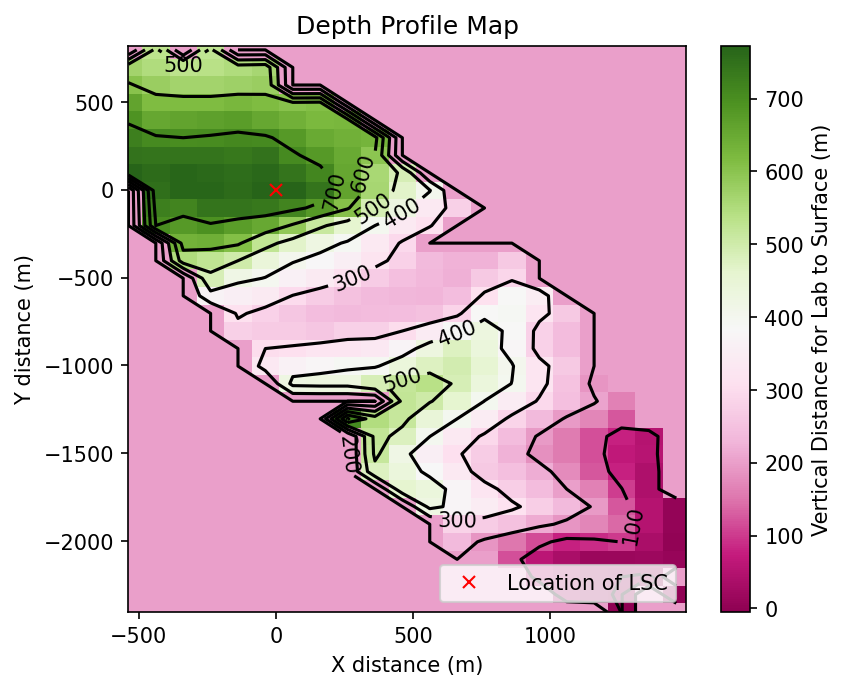

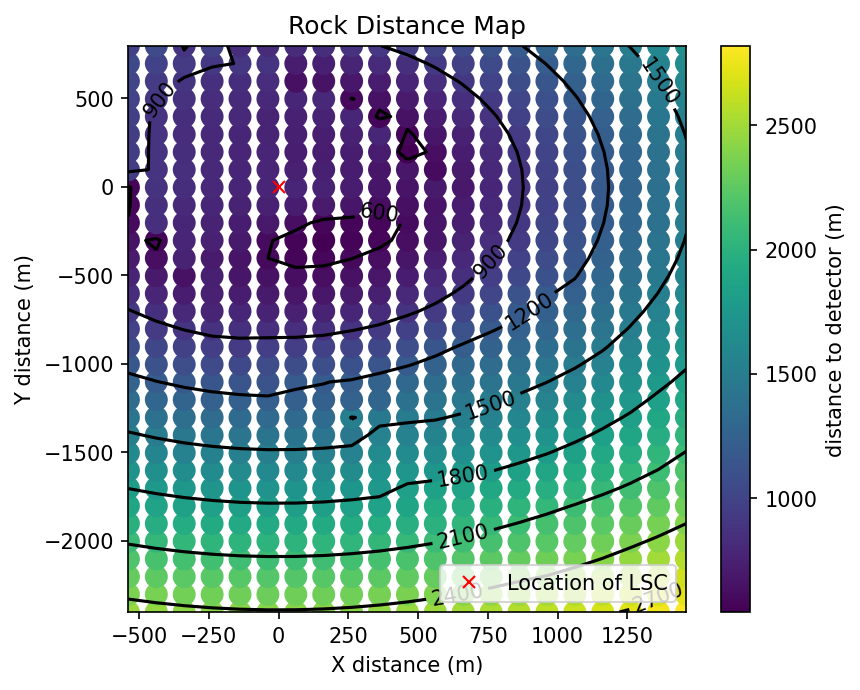

In [6]:
'''cmap = plt.get_cmap('PiYG')
# Plot the height map
plt.figure(figsize=(6,5),dpi=150)
plt.pcolormesh(xx,yy,zz,cmap=cmap,shading='auto')

plt.colorbar(label='Vertical Distance for Lab to Surface (m)')
CS=plt.contour(xx,yy,zz,colors='black')
plt.clabel(CS, inline=1, fontsize=10,fmt='%1.0f')

plt.ylim(Ymin,Ymax)
plt.xlim(Xmin,Xmax)
plt.xlabel("X distance (m)")
plt.ylabel("Y distance (m)")
plt.title("Depth Profile Map")
plt.plot([0],[0],'x',label='Location of LSC',color='red')
plt.legend(loc='lower right')

#Plot the distance from the surface to the lab at each place in XY

plt.figure(figsize=(6,5),dpi=150)
plt.scatter(xx,yy,StepSize,distancetodetector)

plt.colorbar(label='distance to detector (m)')
CS=plt.contour(xx,yy,distancetodetector,colors='black')
plt.clabel(CS, inline=1, fontsize=10,fmt='%1.0f')


plt.xlabel("X distance (m)")
plt.ylabel("Y distance (m)")
plt.title("Rock Distance Map")
plt.plot([0],[0],'x',label='Location of LSC',color='red')
plt.legend(loc='lower right')'''

In [5]:
-505+1105

600

In [5]:
NumToRun=1000
energies=[100,250,500,1000,5000,10000,15000,20000,25000]

#for x in range(-505,1505,500):
for x in range(395,600,500):
    #for y in range(-2255,755,500):
    for y in range(-2255,755,500):        
        #Decide on a place to start a muon from and get its angles and distances:
        startMuon   = (x,y)
        thMuon,phiMuon,depthMuon,distMuon=GetMuonInfo(startMuon)
        print("x,y,theta, phi, depth, distance to det: ",x,y,np.rad2deg(thMuon),np.rad2deg(phiMuon),depthMuon,distMuon)


        srtnrg=[]
        srttheta=[]
        srtphi=[]
        srtdep=[]
        srtdist=[]
        FinalMuons=[]
        FinalPos=[]

        # Run a few energies 
        for nrgs in energies:
            E=nrgs*GeV
            
            FinalMuons0,FinalPos0=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000),dtype=object)
            
            FinalMuons.append(FinalMuons0)
            FinalPos.append(FinalPos0)
            srtnrg.append(np.full((len(FinalPos0)), E))
            srttheta.append(np.full((len(FinalPos0)), thMuon))
            srtphi.append(np.full((len(FinalPos0)), phiMuon))
            srtdep.append(np.full((len(FinalPos0)), depthMuon))
            srtdist.append(np.full((len(FinalPos0)), distMuon))
        
        data_out4 = '/Users/rogerslc/PROPOSAL/PROPOSAL/cartcoord/ProposalMuons'+str(x)+'_'+str(y)+'.h5'
        pd.DataFrame({'Energy':srtnrg,
                      'Theta':srttheta,
                      'Phi':srtphi,
                      'DepthOfDet':srtdep,
                      'DistToDet':srtdist,
                      'FinalMuons':FinalMuons,
                      'FinalPosition':FinalPos}).to_hdf(data_out4,'MuonsProp')

x,y,theta, phi, depth, distance to det:  495 745 77.34930234266115 56.14986392282068 198.57 915.85


theta, phi, depth, distance to det:  1.24 -0.79 241.26 747.1


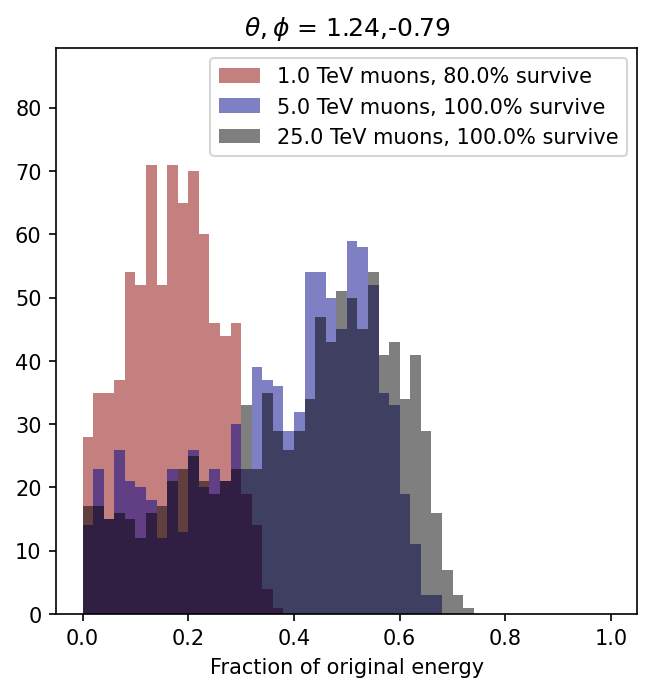

In [10]:
'''NumToRun=1000
#Decide on a place to start a muon from and get its angles and distances:
startMuon   = (500,-500)
thMuon,phiMuon,depthMuon,distMuon=GetMuonInfo(startMuon)
print("theta, phi, depth, distance to det: ", thMuon,phiMuon,depthMuon,distMuon)



# Run a few energies and make a plot

plt.figure(figsize=(5,5),dpi=150)

E=1000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000),dtype=object)
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkRed')
df1=pd.DataFrame([thMuon,phiMuon,depthMuon,distMuon,FinalMuons,FinalPos],columns=['Theta', 'Phi', 'Depth', 'DistToDet', 'FinalMuons','FinalPosition'])
df2=df2.append(df1)

E=5000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000),dtype=object)
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkBlue')

E=25000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000),dtype=object)
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='Black')


plt.legend(loc='upper right')
plt.xlabel("Fraction of original energy")
plt.title(r"$\theta,\phi$ = "+str(thMuon)+"," +str(phiMuon))
plt.ylim(0,plt.gca().get_ylim()[1]*1.2)
plt.show()'''

theta, phi, depth, distance to det:  0.09 0.79 762.01 765.44


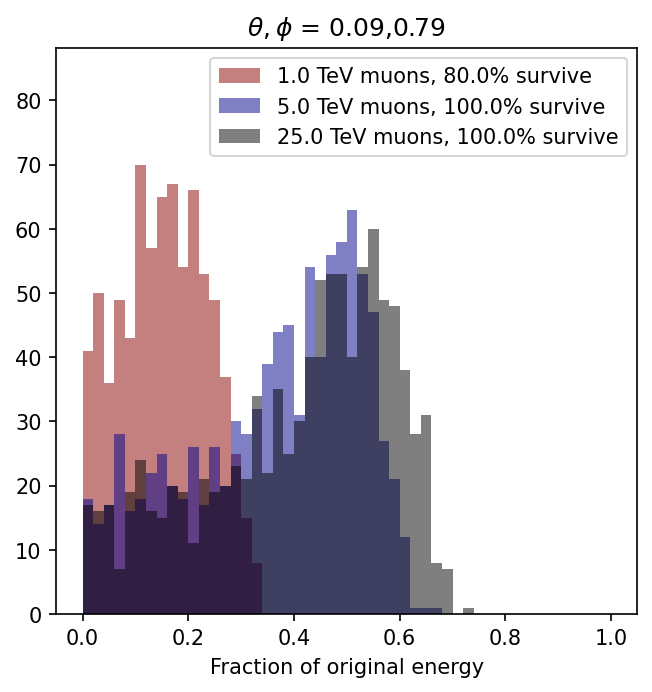

In [8]:
'''NumToRun=1000
#Decide on a place to start a muon from and get its angles and distances:
startMuon   = (-50,-50)
thMuon,phiMuon,depthMuon,distMuon=GetMuonInfo(startMuon)
print("theta, phi, depth, distance to det: ", thMuon,phiMuon,depthMuon,distMuon)



# Run a few energies and make a plot

plt.figure(figsize=(5,5),dpi=150)

E=1000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000),dtype=object)
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkRed')

E=5000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000),dtype=object)
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='DarkBlue')

E=25000*GeV
FinalMuons,FinalPos=np.array(PropagateMuons(E,distMuon*m_to_cm,NumberToRun=1000),dtype=object)
FracSurviving=round(len(FinalMuons)/NumToRun,1)
plt.hist(FinalMuons/E,bins=np.arange(0,1.02,0.02),label=str(E/1e6)+ " TeV muons, "+str(FracSurviving*100)+"% survive",alpha=0.5,color='Black')


plt.legend(loc='upper right')
plt.xlabel("Fraction of original energy")
plt.title(r"$\theta,\phi$ = "+str(thMuon)+"," +str(phiMuon))
plt.ylim(0,plt.gca().get_ylim()[1]*1.2)
plt.show()'''